In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nlp_utils
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
import gensim
import numpy as np
import pandas as pd
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load parsed news dataset
dataset = nlp_utils.NewsTextDataset()
dataset.load("datasets/merged_data_lab_3.json")

In [4]:
# Preprocessing
dataset.preprocess()

6570it [00:57, 114.26it/s]


In [8]:
data = dataset.dump_to_pandas()

Удаляем конструкцию, повторяющуюся в каждом документе 

In [9]:
for idx, text in enumerate(data.tokenized_text):
    data.tokenized_text[idx] = text[3:] if 'тасс' in text else text

In [10]:
data.head()

,category,tokenized_text
0,политика,"[российский, федерация, объединять, арабский, ..."
1,политика,"[премьерминистр, рф, михаил, мишустин, подписы..."
2,политика,"[российский, сми, почувствовать, свободно, сша..."
3,политика,"[возвращение, россия, сша, договор, открытый, ..."
4,политика,"[заместитель, председатель, совет, безопасност..."


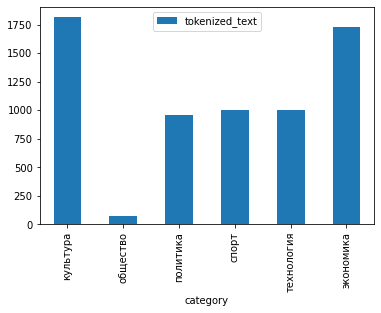

In [11]:
import matplotlib.pyplot as plt
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

Убираем категорию общество, так как количество объектов в ней сильно меньше чем в остальных

In [12]:
data = data[data.category != 'общество']

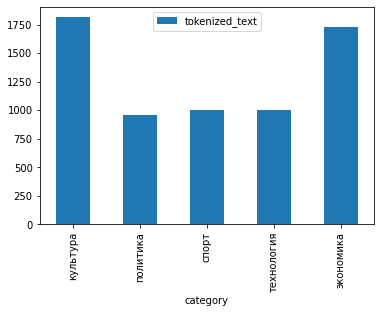

In [13]:
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [14]:
from gensim.corpora import Dictionary
def prep_corpus(docs, no_below=3, no_above=0.5):
    dictionary = Dictionary(docs)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus


#### Create corpus with BOW vectorizer

In [ ]:
dictionary, corpus = prep_corpus(data['tokenized_text'])

#### Create  TFIDF model

In [16]:
from gensim import models

tfidf = models.TfidfModel(corpus, normalize=True)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 6497 documents and 19336 features (832480 matrix non-zeros)


Используя алгоритм Grid Search, со следующими параметрами:
```json
{ 'num_topics': [5, 8, 16, 32],
  'passes': [10, 50, 100],
  'iterations':[50, 100, 500],
  'decay': [0.5, 0.75, 0.9]
}
```
мы получили следующие значения оптимальных параметров для LDA модели:
```json
{
    'num_topics': 5,
    'passes': 50,
    'iterations': 50,
    'decay': 0.75
}
```

В последствие мы будем использовать их для обучения

In [ ]:
# Trying to add GridSearch
from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import LdaTransformer
from sklearn.model_selection import GridSearchCV
param_grid = {'num_topics': [5, 8, 16, 32],
               'passes': [10, 50, 100],
               'iterations':[50, 100, 500],
               'decay': [0.5, 0.75, 0.9]
               }
# Reduce each document to 2 dimensions (topics) using the sklearn interface.
model = LdaTransformer(id2word=dictionary)
sh = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=10).fit(corpus)

In [17]:
corpus_tfidf = tfidf[corpus]

In [ ]:
# Train the model on the TFIDF corpus
lda_tfidf = LdaModel(corpus_tfidf, 
               id2word=dictionary,
               num_topics=5,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42));

In [ ]:
# Train the model on the BOW corpus.
lda = LdaModel(corpus, 
               id2word=dictionary,
               num_topics=5,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42))

### Visalize result with BOW LDA model

In [21]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
pyLDAvis.display(vis_data)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Мы можем визуально определить насколько близко к исходным топикам модель кластеризовала элементы корпуса.

Напомним, что исходными топиками являются: 
- Политика
- Технологии
- Экономика
- Спорт
- Культура

Рассмотрим каждый кластер по очереди:

1) Топ наиболее значимых слов в первом кластере: **рубль**, **россия**, **банк**. Из чего можно сделать вывод, что данный кластер ближе всего к топику "Экономика".

2) Во втором кластере выделяются: **фильм**, **режиссер**, **театр**. Мы можем отнести этот кластер к топику "Культура" 

3) Если внимательно изучить топ значимых слов третьего кластера, можно увидеть такие слова как: **компания**, **сервис**, **система**, **пользователь**. Из этого следует принадлежность этого кластера к топику "Технологии". Но следует заметить, что этот кластер не такой явный, как два предыдущих. Потому что в нем присутствуют так же такие слова как: **российский**, **сша**, **президент**, **страна**, а это явно указатели на топик "Политика", из чего следует, что кластер объединил в себя два топика.

4) Самый неоднозначный кластер, так как в нем явно читается тема, которой не было в изначальном перечне топиков - "Юридическая". На нее указывают такие слова как: **дело**, **нарушение**, **суд**, **право**.  И нужно так же заметить, что и в этот кластер протекли слова, указывающие на политическую тему: **российский**, **россия**, **президент**, **рф** 

Тут можно сделать промежуточный вывод о том, что скорее всего удаление пересекающихся слов в топиках принесло бы улучшение в качестве работы алгоритма.

5) Топ наиболее значимых слов в пятом кластере: **матч**, **команда**, **чемпионат**. Из чего можно сделать уверенный вывод, что данный кластер ближе всего к топику "Спорт".

По графику можно заметить, что кластеры 2 и 5 являются обособленными и не пересекаются с другими. В то время как кластеры 1, 3, 4 имеют явные пересечения, что видно из анализа наиболее значимых слов.

In [26]:
pyLDAvis.save_html(vis_data, 'lda_bow.html')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visalize result with TFIDF LDA model

In [24]:
vis_data_tfidf = gensimvis.prepare(lda_tfidf, corpus_tfidf, dictionary)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
pyLDAvis.display(vis_data_tfidf)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Необходимо заметить, что модель основанная на tfidf векторизации отработала явно хуже. Но это объяснимо так как LDA является вероятностной моделью, которая считает вероятностное распределение топиков в документе  и слов в топике. Взвешивание вероятностей является излишним для LDA модели. Наш эксперимент доказал это. 


Рассмотрим каждый кластер по очереди:

В данном случае явно отделены два кластера: 1 - кластер, который смешал в себе "Экономику" и "Политику" (**компания**,**рубль**,**прездиент**, **сша**). 2 - кластер, который хорошо обосбил "Спорт". Из этих наблюдений подтверждается фраза: "Спорт вне политики"

Сначала мы подумали, что остальные кластеры являются "мусором", но присмотревшись становится понятно, что кластеризация адекватная, но тематика достаточно узкая.

К примеру 2 кластер с ключевыми словами: **карабах**,**нагорный**,**армения**, **азербайджан** явно указывает на военный конфликт произошедший между Армений и Азербайджаном за Нагорный Карабах.

А например 5 кластер с такими словами, как **друзь**,**магистр**,**телепередача**, **знаток** отчетливо отсылает к известной телевезионной игре "ЧГК".

In [27]:
pyLDAvis.save_html(vis_data_tfidf, 'lda_tfidf.html')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def generate_wordcloud(lda_model):
    for t in range(lda_model.num_topics):
        plt.figure()
        plt.imshow(WordCloud(background_color="white").fit_words(dict(lda_model.show_topic(t, 50))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Wordclouds for BOW LDA model

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


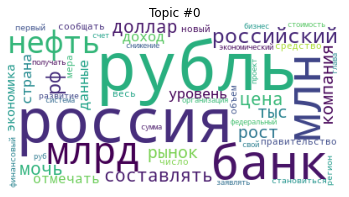

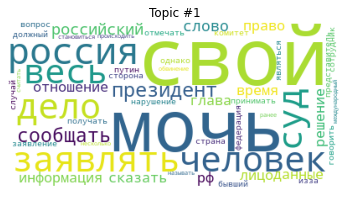

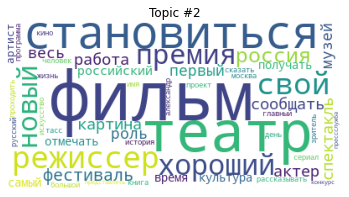

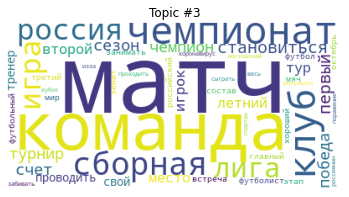

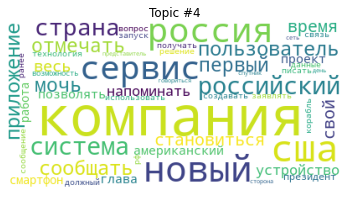

In [29]:
generate_wordcloud(lda)

### Wordcloud for TFIDF LDA model

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


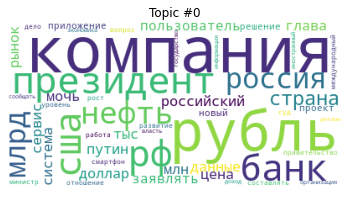

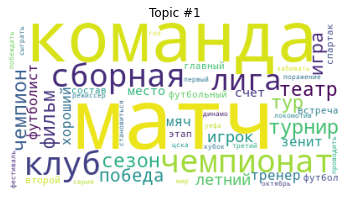

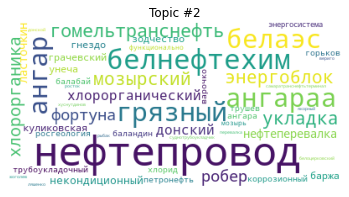

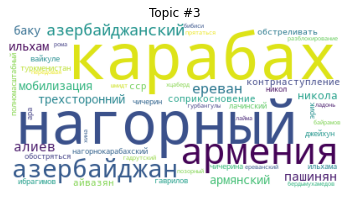

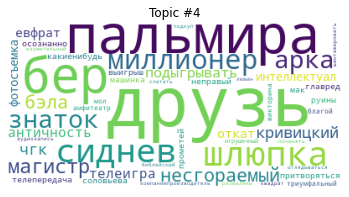

In [30]:
generate_wordcloud(lda_tfidf)

Для наибольшей наглядности предоставляем визуализацию в другом формате, которая подтверждает наши выводы,изложенные выше.

### Coherence Score Calculation for BOW LDA model

In [31]:
import gensim.downloader as api
from gensim.models.coherencemodel import CoherenceModel
w2v_model = api.load("word2vec-ruscorpora-300")

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.utils_any2vec:loading projection weights from /home/alexander/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz
INFO:gensim.models.utils_any2vec:loaded (184973, 300) matrix from /home/alexander/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz


In [32]:
cleaned_w2v_dict = {k.split('_')[0]: v for k, v in w2v_model.vocab.items()}
w2v_model.vocab = cleaned_w2v_dict

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
coherence_model_lda_w2v_bow = CoherenceModel(model=lda, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
coherence_lda = coherence_model_lda_w2v_bow.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5396015


### Coherence Score Calculation for TFIDF LDA model

In [35]:
coherence_model_lda_w2v_tfidf = CoherenceModel(model=lda_tfidf, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
coherence_lda = coherence_model_lda_w2v_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.51873225


У модели с BOW векторизацией когерентность выше, чем у TFIDF based модели, из чего вывод о том, что модель c BOW отработала лучше подтверждается.

## Task 3

In [37]:
data.category.unique()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['политика', 'экономика', 'культура', 'технология', 'спорт'],
      dtype=object)

In [38]:
lda.show_topics()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"рубль" + 0.008*"россия" + 0.006*"банк" + 0.006*"млн" + 0.006*"млрд" + 0.005*"нефть" + 0.005*"российский" + 0.005*"рф" + 0.005*"составлять" + 0.005*"цена"'),
 (1,
  '0.007*"свой" + 0.006*"мочь" + 0.006*"россия" + 0.005*"человек" + 0.005*"дело" + 0.005*"заявлять" + 0.005*"весь" + 0.005*"суд" + 0.005*"президент" + 0.004*"сообщать"'),
 (2,
  '0.010*"фильм" + 0.009*"театр" + 0.006*"становиться" + 0.005*"режиссер" + 0.005*"свой" + 0.005*"хороший" + 0.004*"премия" + 0.004*"новый" + 0.004*"россия" + 0.004*"фестиваль"'),
 (3,
  '0.017*"матч" + 0.012*"команда" + 0.009*"чемпионат" + 0.009*"клуб" + 0.008*"сборная" + 0.007*"россия" + 0.006*"игра" + 0.006*"лига" + 0.006*"становиться" + 0.006*"первый"'),
 (4,
  '0.016*"компания" + 0.006*"сша" + 0.005*"новый" + 0.005*"россия" + 0.005*"сервис" + 0.005*"российский" + 0.005*"система" + 0.004*"страна" + 0.004*"пользователь" + 0.004*"сообщать"')]

In [39]:
# Genereate input for word2vec
def generate_w2vec_distances(lda_model):
    true_topics = ['политика', 'экономика', 'культура','спорт', 'технология']
    all_topic_words = []
    for topic_idx in range(lda_model.num_topics):
        topic_words = []
        for word, _ in lda_model.show_topic(topic_idx, 10):
            try:
                w2v_model.get_vector(word)
                topic_words.append(word)
            except KeyError as msg:
                print(msg)
                continue
        all_topic_words.append(topic_words)
    distances = [[w2v_model.distances(true_topic, generated_topic) for true_topic in true_topics] for generated_topic in all_topic_words]
    return np.array(distances)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


С помощью w2vec модели получаем вектора слов, которые кластеризовала lda модель, а затем считаем расстояние между ними и словами из реального(gt) топика.

## Plot distances for BOW LDA Model

In [40]:
distances_lba = generate_w2vec_distances(lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"word 'свой' not in vocabulary"
"word 'свой' not in vocabulary"


In [41]:
def plot_distances(distances):
    distances_mean = np.array([[np.mean(distances[i][j]) for j in range(distances.shape[0])] for i in range(distances.shape[1])])
    print(distances_mean.shape)
    fig, ax = plt.subplots()
    im = ax.imshow(distances_mean)

    ax.set_xticks(np.arange(distances_mean.shape[0]))
    ax.set_yticks(np.arange(distances_mean.shape[1]))
    ax.set_xticklabels(data.category.unique())
    ax.set_yticklabels([f'topic {i}' for i in range(distances_mean.shape[1])])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(distances_mean.shape[0]):
        for j in range(distances_mean.shape[1]):
            text = ax.text(j, i, round(distances_mean[i, j], 2),
                           ha="center", va="center", color="r")

    ax.set_title("Cosine similarities between true and predicted topics")
    fig.tight_layout()
    plt.show()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5, 5)


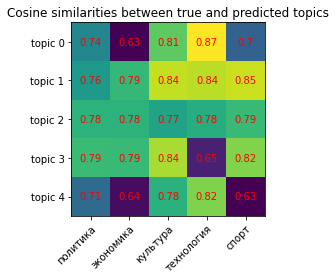

In [42]:
plot_distances(distances_lba)

## Plot distances for TF-IDF LDA Model

In [43]:
distances_lba_tf_idf = generate_w2vec_distances(lda_tfidf)

"word 'белнефтехим' not in vocabulary"
"word 'белаэс' not in vocabulary"
"word 'ангараа' not in vocabulary"
"word 'гомельтранснефть' not in vocabulary"
"word 'пашинян' not in vocabulary"
"word 'ильхам' not in vocabulary"


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5, 5)


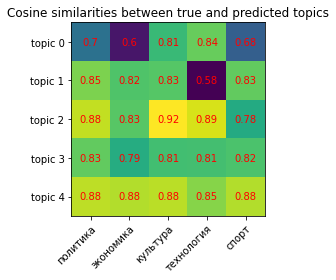

In [44]:
plot_distances(distances_lba_tf_idf)

## PLSA

In [45]:
from nltk.corpus import stopwords
from plsa.preprocessors import *

RUSSIAN_DEFAULT_PIPELINE = (
    tokenize,
    remove_short_words(2),
)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
import csv
from numpy import zeros, ndarray, log, sign, abs
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
plsa_corpus_csv = data.copy()
for i, string in enumerate(plsa_corpus_csv['tokenized_text']):
    plsa_corpus_csv.iloc[i]['tokenized_text'] = ' '.join(string)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# plsa_corpus_csv['tokenized_text'] = plsa_corpus_csv['tokenized_text']
plsa_corpus_csv.to_csv('datasets/corpus.csv')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
pipeline = Pipeline(*RUSSIAN_DEFAULT_PIPELINE)
corpus = Corpus.from_csv('datasets/corpus.csv', pipeline, col=-1, encoding='utf-8', max_docs=10000)
corpus

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Corpus:
Number of documents: 6497
Number of words:     47361

In [50]:
n_topics = 5

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
plsa = PLSA(corpus, n_topics, True)
plsa

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PLSA:
====
Number of topics:     5
Number of documents:  6497
Number of words:      47361
Number of iterations: 0

In [52]:
result = plsa.fit()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
result.topic

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.26835033, 0.25939365, 0.20711501, 0.13431698, 0.13082403])

In [54]:
visualize = Visualize(result)
visualize

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualize:
Number of topics:    5
Number of documents: 6497
Number of words:     47361

In [55]:
result.word_given_topic[3][:10]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(('матч', 0.005942541730977233),
 ('команда', 0.004231054022636532),
 ('сборная', 0.003958473839074645),
 ('чемпионат', 0.0036091506752964986),
 ('клуб', 0.0035054872867254297),
 ('корабль', 0.0028610979392264687),
 ('лига', 0.0027993733625343606),
 ('турнир', 0.0026781518987384722),
 ('игра', 0.002608410807517777),
 ('чемпион', 0.0025983307816714123))

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


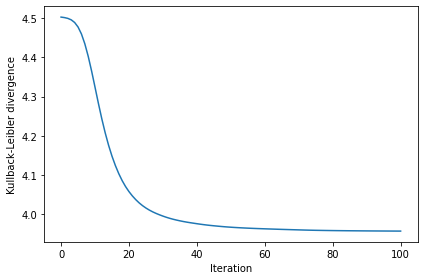

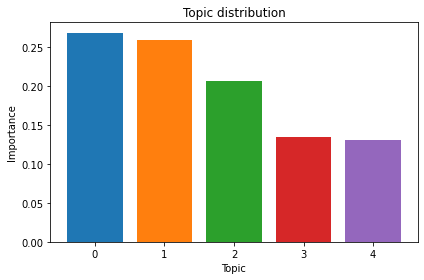

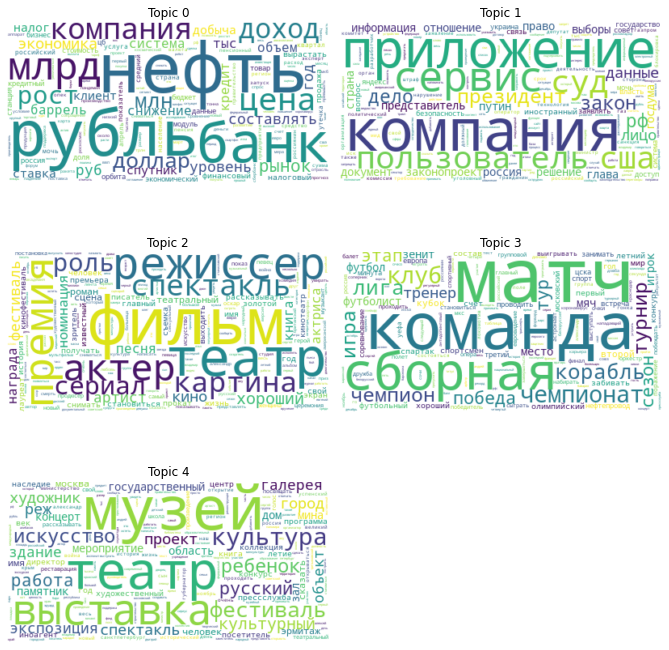

In [56]:
fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()


fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()


fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)



In [63]:
def generate_w2vec_distances_plsa(plsa_result):
    true_topics = ['политика', 'экономика', 'культура','спорт', 'технология']
    all_topic_words = []
    for topic_idx in range(len(plsa_result.word_given_topic)):
        topic_words = []
        for word, _ in plsa_result.word_given_topic[topic_idx][:10]:
            try:
                w2v_model.get_vector(word)
                topic_words.append(word)
            except KeyError as msg:
                print(msg)
                continue
        all_topic_words.append(topic_words)
    distances = [[w2v_model.distances(true_topic, generated_topic) for true_topic in true_topics] for generated_topic in all_topic_words]
    return np.array(distances)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
distances_plsa = generate_w2vec_distances_plsa(result)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5, 5)


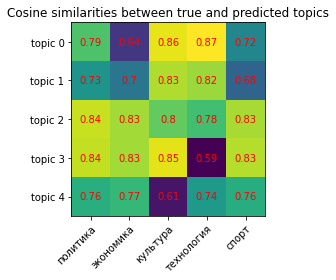

In [65]:
plot_distances(distances_plsa)